<a href="https://colab.research.google.com/github/iamshanevictor/CXRaide2.0-Model_Training/blob/main/ITERATION_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

def count_images_in_folder(folder_path):
    # Define image extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

    # Initialize image count
    image_count = 0

    # Walk through the folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_count += 1

    return image_count

# Define the paths to the folders
folder1 = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/TRAINING_300'
folder2 = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALIDATION_300'

# Count images in both folders
count1 = count_images_in_folder(folder1)
count2 = count_images_in_folder(folder2)

# Print the results
print(f"Number of images in folder 1: {count1}")
print(f"Number of images in folder 2: {count2}")
print(f"total: {count1 + count2}")

Number of images in folder 1: 1211
Number of images in folder 2: 550
total: 1761


In [ ]:
# Install required libraries
!pip install torchmetrics

import torch
import torchmetrics
from torchvision.models.detection import ssd300_vgg16
from torchvision.ops import nms
from torch.utils.data import Dataset, DataLoader
import os
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch import optim
from tqdm import tqdm
from collections import defaultdict
from torchmetrics.detection import MeanAveragePrecision
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset class (unchanged)
class CustomDataset(Dataset):
    def __init__(self, root, bbox_csv, multi_label_csv, transform=None):
        self.root = root
        self.bbox_annotations = pd.read_csv(bbox_csv)
        self.multi_label_annotations = pd.read_csv(multi_label_csv)
        self.transform = transform

    def __len__(self):
        return len(self.bbox_annotations)

    def __getitem__(self, idx):
        try:
            img_name = os.path.join(self.root, 'JPEGImages', self.bbox_annotations.iloc[idx, 0] + '.png')
            image = Image.open(img_name).convert("RGB")
            bbox = self.bbox_annotations.iloc[idx, 2:6].values.astype('float').reshape(-1, 4)
            class_name = self.bbox_annotations.iloc[idx, 1]

            multi_labels = self.multi_label_annotations[self.multi_label_annotations['image_id'] == self.bbox_annotations.iloc[idx, 0]].iloc[:, 1:].values.astype('int')[0]

            if len(bbox) == 0:
                bbox = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros((0,), dtype=torch.int64)
            else:
                class_to_idx = {"Cardiomegaly": 1, "Pleural thickening": 2, "Pulmonary fibrosis": 3,
                                "Pleural effusion": 4, "Nodule/Mass": 5, "Infiltration": 6, "Consolidation": 7, "Atelectasis": 8, "Pneumothorax": 9}
                labels = torch.tensor([class_to_idx[class_name]], dtype=torch.int64)

            target = {
                "boxes": torch.as_tensor(bbox, dtype=torch.float32),
                "labels": labels.clone().detach().to(torch.int64),
                "multi_labels": torch.tensor(multi_labels, dtype=torch.int64)
            }

            if self.transform:
                image = self.transform(image)

            return image, target
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            return None

# Collate function
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return tuple(zip(*batch))

# Dataset transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Dataset paths
root = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VOCdevkit/VOC2007'
bbox_train_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/train.csv'
multi_label_train_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/TRAINtrans.csv'
bbox_val_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/val.csv'
multi_label_val_csv = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALtrans.csv'

train_dataset = CustomDataset(root=root, bbox_csv=bbox_train_csv, multi_label_csv=multi_label_train_csv, transform=data_transform)
val_dataset = CustomDataset(root=root, bbox_csv=bbox_val_csv, multi_label_csv=multi_label_val_csv, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

# SSD300 model
model = ssd300_vgg16(pretrained=True)
num_classes = 10  # 9 classes + 1 background class
model.head.classification_head.num_classes = num_classes
model.to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0005)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, threshold=1e-4, verbose=True)

# Metrics
metric_ap = MeanAveragePrecision(iou_type='bbox', class_metrics=True)

# Non-Maximum Suppression (NMS) function
def apply_nms(outputs, iou_threshold=0.5):
    nms_outputs = []
    for output in outputs:
        if len(output['boxes']) > 0:
            keep_indices = nms(output['boxes'], output['scores'], iou_threshold)
            nms_outputs.append({
                'boxes': output['boxes'][keep_indices],
                'scores': output['scores'][keep_indices],
                'labels': output['labels'][keep_indices],
            })
        else:
            nms_outputs.append(output)
    return nms_outputs

# Calculate class weights for imbalance handling
class_counts = train_dataset.bbox_annotations['class_name'].value_counts()
total_samples = class_counts.sum()
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Custom weighted loss function
def custom_loss_fn(loss_dict, targets, class_weights):
    classification_loss = 0.0
    regression_loss = loss_dict['bbox_regression']
    for target, logits in zip(targets, loss_dict['classification']):
        labels = target['labels']
        weights = torch.tensor([class_weights[int(label)] for label in labels]).to(logits.device)
        classification_loss += F.cross_entropy(logits, labels, weight=weights)
    return classification_loss, regression_loss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 16.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 180MB/s]


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assuming you have already defined your model, dataloaders, device, etc.

# Define the custom loss function
def custom_loss_fn(loss_dict, targets, class_weights):
    """
    Custom loss function to apply class weights.

    Args:
    - loss_dict: Dictionary containing loss components (classification, bbox regression).
    - targets: Ground truth targets (used to calculate per-class weights).
    - class_weights: Tensor containing class weights for classification loss.

    Returns:
    - cls_loss: Weighted classification loss.
    - loc_loss: Localization loss.
    """
    # Extract losses from the dictionary
    cls_loss = loss_dict['classification']  # Scalar
    loc_loss = loss_dict['bbox_regression']  # Scalar

    # Apply class weights to classification loss
    # Ensure cls_loss is weighted correctly by the provided class_weights
    weighted_cls_loss = cls_loss * torch.mean(class_weights)

    return weighted_cls_loss, loc_loss

# Set up your optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Set the class weights (example; modify according to your dataset)
class_weights = torch.tensor([1.0, 1.2, 0.8, 1.5, 1.0, 1.3, 1.1]).to(device)

# Training loop
num_epochs = 150  # You can update this to any desired number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    classification_loss = 0.0
    localization_loss = 0.0

    # Training process
    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Progress")):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        total_loss = sum(loss for loss in loss_dict.values())

        # Calculate custom loss with class weights
        cls_loss, loc_loss = custom_loss_fn(loss_dict, targets, class_weights)
        total_loss = cls_loss + loc_loss

        # Backpropagate and optimize
        total_loss.backward()
        optimizer.step()

        # Track the losses
        running_loss += total_loss.item()
        classification_loss += cls_loss.item()
        localization_loss += loc_loss.item()

    # Print loss statistics for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader):.4f}")

    # Save the model only every nth epoch (e.g., every 2nd epoch)
    if (epoch + 1) % 20 == 0:
        model_path = f'/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

        # Print detailed loss values only when model is saved
        print(f"Loss Details for Epoch {epoch + 1}:")
        print(f"  ● Classification Loss: {classification_loss / len(train_loader):.8f}")
        print(f"  ● Localization Loss: {localization_loss / len(train_loader):.8f}")
        print(f"  ● Total Loss: {running_loss / len(train_loader):.8f}")

        # Evaluate the model and print AP/AR only after saving the model
        model.eval()
        all_predictions = []
        all_targets = []

        # Run evaluation on the validation set
        for images, targets in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                outputs = model(images)

            # Collecting ground truth and predictions
            for output, target in zip(outputs, targets):
                boxes = output['boxes'].to(device).cpu()
                labels = output['labels'].to(device).cpu()
                scores = output['scores'].to(device).cpu()

                all_predictions.append({
                    'boxes': boxes,
                    'labels': labels,
                    'scores': scores
                })

                target_boxes = target['boxes'].to(device).cpu()
                target_labels = target['labels'].to(device).cpu()

                all_targets.append({
                    'boxes': target_boxes,
                    'labels': target_labels
                })

        # Calculate the Average Precision (AP)
        metric_ap.update(all_predictions, all_targets)

        # Get AP for the current epoch
        ap_results = metric_ap.compute()

        # Print results with improved formatting
        print(f"Average Precision (AP) for Epoch {epoch + 1}:")
        print(f"  - mAP: {ap_results['map']:.4f}")
        print(f"  - mAP@0.50: {ap_results['map_50']:.4f}")
        print(f"  - mAP@0.75: {ap_results['map_75']:.4f}")
        print(f"  - mAP (small): {ap_results['map_small']:.4f}")
        print(f"  - mAP (medium): {ap_results['map_medium']:.4f}")
        print(f"  - mAP (large): {ap_results['map_large']:.4f}")
        print(f"Average Recall (AR) for Epoch {epoch + 1}:")
        print(f"  - AR@1: {ap_results['mar_1']:.4f}")
        print(f"  - AR@10: {ap_results['mar_10']:.4f}")
        print(f"  - AR@100: {ap_results['mar_100']:.4f}")
        print(f"  - AR (small): {ap_results['mar_small']:.4f}")
        print(f"  - AR (medium): {ap_results['mar_medium']:.4f}")
        print(f"  - AR (large): {ap_results['mar_large']:.4f}")

        # Only print per-class results for classes in your dataset (1-7)
        print(f"Per-Class mAP for Epoch {epoch + 1}:")
        for class_idx, ap_class in enumerate(ap_results['map_per_class']):
            if class_idx < 9:  # Only print classes 1 to 7
                print(f"  - Class {class_idx + 1}: {ap_class:.4f}")

        print(f"Per-Class AR (at 100 detections) for Epoch {epoch + 1}:")
        for class_idx, ar_class in enumerate(ap_results['mar_100_per_class']):
            if class_idx < 9:  # Only print classes 1 to 7
                print(f"  - Class {class_idx + 1}: {ar_class:.4f}")

        # Reset metrics for the next epoch
        metric_ap.reset()


Epoch 1 Progress: 100%|██████████| 176/176 [05:45<00:00,  1.96s/it]


Epoch [1/150] Loss: 8.2683


Epoch 2 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.52it/s]


Epoch [2/150] Loss: 6.8612


Epoch 3 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.52it/s]


Epoch [3/150] Loss: 6.3784


Epoch 4 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.82it/s]


Epoch [4/150] Loss: 6.0188


Epoch 5 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [5/150] Loss: 5.7012


Epoch 6 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.49it/s]


Epoch [6/150] Loss: 5.4267


Epoch 7 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.32it/s]


Epoch [7/150] Loss: 5.1434


Epoch 8 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [8/150] Loss: 4.9278


Epoch 9 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.52it/s]


Epoch [9/150] Loss: 4.7518


Epoch 10 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [10/150] Loss: 4.5809


Epoch 11 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.75it/s]


Epoch [11/150] Loss: 4.4178


Epoch 12 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [12/150] Loss: 4.2803


Epoch 13 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.79it/s]


Epoch [13/150] Loss: 4.1664


Epoch 14 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [14/150] Loss: 4.0630


Epoch 15 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.82it/s]


Epoch [15/150] Loss: 3.9592


Epoch 16 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.54it/s]


Epoch [16/150] Loss: 3.8730


Epoch 17 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [17/150] Loss: 3.8047


Epoch 18 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.64it/s]


Epoch [18/150] Loss: 3.7336


Epoch 19 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [19/150] Loss: 3.6615


Epoch 20 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.52it/s]


Epoch [20/150] Loss: 3.6007


Epoch 21 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.51it/s]


Epoch [21/150] Loss: 3.5354


Epoch 22 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.83it/s]


Epoch [22/150] Loss: 3.5030


Epoch 23 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.77it/s]


Epoch [23/150] Loss: 3.4443


Epoch 24 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.49it/s]


Epoch [24/150] Loss: 3.4108


Epoch 25 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [25/150] Loss: 3.3509


Epoch 26 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s]


Epoch [26/150] Loss: 3.3099


Epoch 27 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]


Epoch [27/150] Loss: 3.2758


Epoch 28 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.74it/s]


Epoch [28/150] Loss: 3.2372


Epoch 29 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]


Epoch [29/150] Loss: 3.1938


Epoch 30 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [30/150] Loss: 3.1708
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_30.pth
Loss Details for Epoch 30:
  ● Classification Loss: 2.87344752
  ● Localization Loss: 0.29732638
  ● Total Loss: 3.17077390


Validation Epoch 30: 100%|██████████| 704/704 [01:12<00:00,  9.66it/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Average Precision (AP) for Epoch 30:
  - mAP: 0.0087
  - mAP@0.50: 0.0219
  - mAP@0.75: 0.0044
  - mAP (small): 0.0012
  - mAP (medium): 0.0123
  - mAP (large): 0.0098
Average Recall (AR) for Epoch 30:
  - AR@1: 0.0855
  - AR@10: 0.1250
  - AR@100: 0.1393
  - AR (small): 0.0571
  - AR (medium): 0.1315
  - AR (large): 0.1359
Per-Class mAP for Epoch 30:
  - Class 1: 0.0698
  - Class 2: 0.0006
  - Class 3: 0.0002
  - Class 4: 0.0027
  - Class 5: 0.0005
  - Class 6: 0.0006
  - Class 7: 0.0010
  - Class 8: 0.0002
  - Class 9: 0.0024
Per-Class AR (at 100 detections) for Epoch 30:
  - Class 1: 0.4787
  - Class 2: 0.1403
  - Class 3: 0.0576
  - Class 4: 0.1857
  - Class 5: 0.0589
  - Class 6: 0.0902
  - Class 7: 0.0796
  - Class 8: 0.0419
  - Class 9: 0.1206


Epoch 31 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.77it/s]


Epoch [31/150] Loss: 3.1404


Epoch 32 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [32/150] Loss: 3.0932


Epoch 33 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.86it/s]


Epoch [33/150] Loss: 3.0729


Epoch 34 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [34/150] Loss: 3.0402


Epoch 35 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.82it/s]


Epoch [35/150] Loss: 3.0099


Epoch 36 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.79it/s]


Epoch [36/150] Loss: 2.9994


Epoch 37 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [37/150] Loss: 2.9563


Epoch 38 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.83it/s]


Epoch [38/150] Loss: 2.9447


Epoch 39 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.77it/s]


Epoch [39/150] Loss: 2.9208


Epoch 40 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.83it/s]


Epoch [40/150] Loss: 2.8951


Epoch 41 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.82it/s]


Epoch [41/150] Loss: 2.8809


Epoch 42 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [42/150] Loss: 2.8659


Epoch 43 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [43/150] Loss: 2.8496


Epoch 44 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.79it/s]


Epoch [44/150] Loss: 2.8023


Epoch 45 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [45/150] Loss: 2.8016


Epoch 46 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.63it/s]


Epoch [46/150] Loss: 2.7828


Epoch 47 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.75it/s]


Epoch [47/150] Loss: 2.7665


Epoch 48 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.74it/s]


Epoch [48/150] Loss: 2.7412


Epoch 49 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.76it/s]


Epoch [49/150] Loss: 2.7345


Epoch 50 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [50/150] Loss: 2.7156


Epoch 51 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.76it/s]


Epoch [51/150] Loss: 2.7144


Epoch 52 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.81it/s]


Epoch [52/150] Loss: 2.6801


Epoch 53 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.76it/s]


Epoch [53/150] Loss: 2.6779


Epoch 54 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.82it/s]


Epoch [54/150] Loss: 2.6665


Epoch 55 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.78it/s]


Epoch [55/150] Loss: 2.6435


Epoch 56 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.77it/s]


Epoch [56/150] Loss: 2.6395


Epoch 57 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.57it/s]


Epoch [57/150] Loss: 2.6191


Epoch 58 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.80it/s]


Epoch [58/150] Loss: 2.6016


Epoch 59 Progress: 100%|██████████| 176/176 [00:25<00:00,  6.81it/s]


Epoch [59/150] Loss: 2.5925


Epoch 60 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.73it/s]


Epoch [60/150] Loss: 2.5801
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_60.pth
Loss Details for Epoch 60:
  ● Classification Loss: 2.45083114
  ● Localization Loss: 0.12929142
  ● Total Loss: 2.58012255


Validation Epoch 60: 100%|██████████| 704/704 [00:22<00:00, 31.66it/s]


Average Precision (AP) for Epoch 60:
  - mAP: 0.0088
  - mAP@0.50: 0.0210
  - mAP@0.75: 0.0054
  - mAP (small): 0.0011
  - mAP (medium): 0.0066
  - mAP (large): 0.0112
Average Recall (AR) for Epoch 60:
  - AR@1: 0.1050
  - AR@10: 0.1441
  - AR@100: 0.1583
  - AR (small): 0.0773
  - AR (medium): 0.1534
  - AR (large): 0.1418
Per-Class mAP for Epoch 60:
  - Class 1: 0.0679
  - Class 2: 0.0006
  - Class 3: 0.0004
  - Class 4: 0.0038
  - Class 5: 0.0005
  - Class 6: 0.0006
  - Class 7: 0.0017
  - Class 8: 0.0002
  - Class 9: 0.0033
Per-Class AR (at 100 detections) for Epoch 60:
  - Class 1: 0.5106
  - Class 2: 0.1903
  - Class 3: 0.0907
  - Class 4: 0.2286
  - Class 5: 0.0877
  - Class 6: 0.0705
  - Class 7: 0.1429
  - Class 8: 0.0302
  - Class 9: 0.0735


Epoch 61 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.37it/s]


Epoch [61/150] Loss: 2.5755


Epoch 62 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [62/150] Loss: 2.5731


Epoch 63 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [63/150] Loss: 2.5578


Epoch 64 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [64/150] Loss: 2.5490


Epoch 65 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [65/150] Loss: 2.5348


Epoch 66 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [66/150] Loss: 2.5267


Epoch 67 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [67/150] Loss: 2.5040


Epoch 68 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [68/150] Loss: 2.5086


Epoch 69 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]


Epoch [69/150] Loss: 2.4918


Epoch 70 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [70/150] Loss: 2.4772


Epoch 71 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [71/150] Loss: 2.4663


Epoch 72 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [72/150] Loss: 2.4778


Epoch 73 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [73/150] Loss: 2.4534


Epoch 74 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]


Epoch [74/150] Loss: 2.4502


Epoch 75 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [75/150] Loss: 2.4444


Epoch 76 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [76/150] Loss: 2.4303


Epoch 77 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]


Epoch [77/150] Loss: 2.4267


Epoch 78 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [78/150] Loss: 2.4102


Epoch 79 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [79/150] Loss: 2.4125


Epoch 80 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.35it/s]


Epoch [80/150] Loss: 2.4036


Epoch 81 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [81/150] Loss: 2.3865


Epoch 82 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [82/150] Loss: 2.3712


Epoch 83 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [83/150] Loss: 2.3742


Epoch 84 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [84/150] Loss: 2.3759


Epoch 85 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [85/150] Loss: 2.3722


Epoch 86 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [86/150] Loss: 2.3647


Epoch 87 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [87/150] Loss: 2.3674


Epoch 88 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [88/150] Loss: 2.3394


Epoch 89 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [89/150] Loss: 2.3489


Epoch 90 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [90/150] Loss: 2.3331
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_90.pth
Loss Details for Epoch 90:
  ● Classification Loss: 2.23788948
  ● Localization Loss: 0.09516591
  ● Total Loss: 2.33305539


Validation Epoch 90: 100%|██████████| 704/704 [00:21<00:00, 32.14it/s]


Average Precision (AP) for Epoch 90:
  - mAP: 0.0095
  - mAP@0.50: 0.0232
  - mAP@0.75: 0.0064
  - mAP (small): 0.0007
  - mAP (medium): 0.0095
  - mAP (large): 0.0116
Average Recall (AR) for Epoch 90:
  - AR@1: 0.1096
  - AR@10: 0.1636
  - AR@100: 0.1803
  - AR (small): 0.0845
  - AR (medium): 0.1615
  - AR (large): 0.1988
Per-Class mAP for Epoch 90:
  - Class 1: 0.0753
  - Class 2: 0.0008
  - Class 3: 0.0004
  - Class 4: 0.0028
  - Class 5: 0.0005
  - Class 6: 0.0010
  - Class 7: 0.0016
  - Class 8: 0.0004
  - Class 9: 0.0023
Per-Class AR (at 100 detections) for Epoch 90:
  - Class 1: 0.5128
  - Class 2: 0.1843
  - Class 3: 0.0924
  - Class 4: 0.2459
  - Class 5: 0.1397
  - Class 6: 0.1246
  - Class 7: 0.1755
  - Class 8: 0.0419
  - Class 9: 0.1059


Epoch 91 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.68it/s]


Epoch [91/150] Loss: 2.3314


Epoch 92 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [92/150] Loss: 2.3173


Epoch 93 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.67it/s]


Epoch [93/150] Loss: 2.3211


Epoch 94 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.70it/s]


Epoch [94/150] Loss: 2.3122


Epoch 95 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.74it/s]


Epoch [95/150] Loss: 2.3049


Epoch 96 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.50it/s]


Epoch [96/150] Loss: 2.3009


Epoch 97 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [97/150] Loss: 2.3016


Epoch 98 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.70it/s]


Epoch [98/150] Loss: 2.2855


Epoch 99 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.73it/s]


Epoch [99/150] Loss: 2.2821


Epoch 100 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.72it/s]


Epoch [100/150] Loss: 2.2789


Epoch 101 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.66it/s]


Epoch [101/150] Loss: 2.2724


Epoch 102 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.70it/s]


Epoch [102/150] Loss: 2.2561


Epoch 103 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.58it/s]


Epoch [103/150] Loss: 2.2658


Epoch 104 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s]


Epoch [104/150] Loss: 2.2498


Epoch 105 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s]


Epoch [105/150] Loss: 2.2563


Epoch 106 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.68it/s]


Epoch [106/150] Loss: 2.2615


Epoch 107 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.69it/s]


Epoch [107/150] Loss: 2.2380


Epoch 108 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.71it/s]


Epoch [108/150] Loss: 2.2357


Epoch 109 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [109/150] Loss: 2.2239


Epoch 110 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.72it/s]


Epoch [110/150] Loss: 2.2212


Epoch 111 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.73it/s]


Epoch [111/150] Loss: 2.2217


Epoch 112 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.74it/s]


Epoch [112/150] Loss: 2.2211


Epoch 113 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.68it/s]


Epoch [113/150] Loss: 2.2214


Epoch 114 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.61it/s]


Epoch [114/150] Loss: 2.2070


Epoch 115 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.72it/s]


Epoch [115/150] Loss: 2.2001


Epoch 116 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.63it/s]


Epoch [116/150] Loss: 2.2045


Epoch 117 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.67it/s]


Epoch [117/150] Loss: 2.2086


Epoch 118 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.72it/s]


Epoch [118/150] Loss: 2.1981


Epoch 119 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.75it/s]


Epoch [119/150] Loss: 2.1999


Epoch 120 Progress: 100%|██████████| 176/176 [00:26<00:00,  6.72it/s]


Epoch [120/150] Loss: 2.1935
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_120.pth
Loss Details for Epoch 120:
  ● Classification Loss: 2.11108664
  ● Localization Loss: 0.08245170
  ● Total Loss: 2.19353834


Validation Epoch 120: 100%|██████████| 704/704 [00:21<00:00, 32.55it/s]


Average Precision (AP) for Epoch 120:
  - mAP: 0.0090
  - mAP@0.50: 0.0223
  - mAP@0.75: 0.0060
  - mAP (small): 0.0011
  - mAP (medium): 0.0074
  - mAP (large): 0.0110
Average Recall (AR) for Epoch 120:
  - AR@1: 0.1074
  - AR@10: 0.1673
  - AR@100: 0.1779
  - AR (small): 0.1064
  - AR (medium): 0.1553
  - AR (large): 0.1815
Per-Class mAP for Epoch 120:
  - Class 1: 0.0700
  - Class 2: 0.0012
  - Class 3: 0.0008
  - Class 4: 0.0045
  - Class 5: 0.0005
  - Class 6: 0.0005
  - Class 7: 0.0012
  - Class 8: 0.0006
  - Class 9: 0.0019
Per-Class AR (at 100 detections) for Epoch 120:
  - Class 1: 0.5160
  - Class 2: 0.2172
  - Class 3: 0.1305
  - Class 4: 0.2878
  - Class 5: 0.1096
  - Class 6: 0.0754
  - Class 7: 0.1286
  - Class 8: 0.0628
  - Class 9: 0.0735


Epoch 121 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.38it/s]


Epoch [121/150] Loss: 2.1843


Epoch 122 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [122/150] Loss: 2.1741


Epoch 123 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [123/150] Loss: 2.1828


Epoch 124 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [124/150] Loss: 2.1715


Epoch 125 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [125/150] Loss: 2.1604


Epoch 126 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.45it/s]


Epoch [126/150] Loss: 2.1564


Epoch 127 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [127/150] Loss: 2.1571


Epoch 128 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]


Epoch [128/150] Loss: 2.1533


Epoch 129 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [129/150] Loss: 2.1453


Epoch 130 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [130/150] Loss: 2.1605


Epoch 131 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [131/150] Loss: 2.1474


Epoch 132 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]


Epoch [132/150] Loss: 2.1536


Epoch 133 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.48it/s]


Epoch [133/150] Loss: 2.1472


Epoch 134 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [134/150] Loss: 2.1431


Epoch 135 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [135/150] Loss: 2.1362


Epoch 136 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [136/150] Loss: 2.1341


Epoch 137 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [137/150] Loss: 2.1309


Epoch 138 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.31it/s]


Epoch [138/150] Loss: 2.1238


Epoch 139 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [139/150] Loss: 2.1267


Epoch 140 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.43it/s]


Epoch [140/150] Loss: 2.1231


Epoch 141 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [141/150] Loss: 2.1190


Epoch 142 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.50it/s]


Epoch [142/150] Loss: 2.1134


Epoch 143 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.42it/s]


Epoch [143/150] Loss: 2.1178


Epoch 144 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [144/150] Loss: 2.1089


Epoch 145 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.44it/s]


Epoch [145/150] Loss: 2.1089


Epoch 146 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.47it/s]


Epoch [146/150] Loss: 2.0980


Epoch 147 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.46it/s]


Epoch [147/150] Loss: 2.1004


Epoch 148 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.40it/s]


Epoch [148/150] Loss: 2.1016


Epoch 149 Progress: 100%|██████████| 176/176 [00:28<00:00,  6.26it/s]


Epoch [149/150] Loss: 2.1037


Epoch 150 Progress: 100%|██████████| 176/176 [00:27<00:00,  6.41it/s]


Epoch [150/150] Loss: 2.0985
Model saved to /content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_150.pth
Loss Details for Epoch 150:
  ● Classification Loss: 2.02043538
  ● Localization Loss: 0.07807265
  ● Total Loss: 2.09850803


Validation Epoch 150: 100%|██████████| 704/704 [00:21<00:00, 32.56it/s]


Average Precision (AP) for Epoch 150:
  - mAP: 0.0092
  - mAP@0.50: 0.0217
  - mAP@0.75: 0.0051
  - mAP (small): 0.0011
  - mAP (medium): 0.0102
  - mAP (large): 0.0110
Average Recall (AR) for Epoch 150:
  - AR@1: 0.1138
  - AR@10: 0.1622
  - AR@100: 0.1656
  - AR (small): 0.1043
  - AR (medium): 0.1599
  - AR (large): 0.1582
Per-Class mAP for Epoch 150:
  - Class 1: 0.0717
  - Class 2: 0.0022
  - Class 3: 0.0004
  - Class 4: 0.0038
  - Class 5: 0.0005
  - Class 6: 0.0006
  - Class 7: 0.0012
  - Class 8: 0.0006
  - Class 9: 0.0019
Per-Class AR (at 100 detections) for Epoch 150:
  - Class 1: 0.4819
  - Class 2: 0.1970
  - Class 3: 0.0932
  - Class 4: 0.2745
  - Class 5: 0.1123
  - Class 6: 0.0820
  - Class 7: 0.1082
  - Class 8: 0.0558
  - Class 9: 0.0853


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:06<00:00, 79.6MB/s]
<ipython-input-3-cd3f1adb00ea>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unp

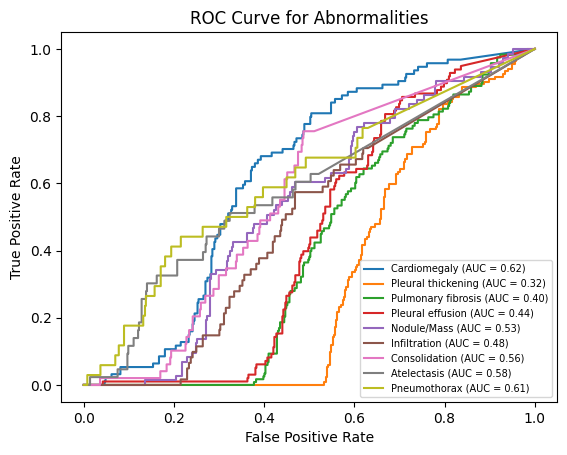

In [ ]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Define the model architecture
model = ssd300_vgg16(pretrained=False)
model.load_state_dict(torch.load('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_150.pth'))
model.eval()

# Function to read and preprocess an image
def load_image_into_numpy_array(image_path):
    image = Image.open(image_path).convert("RGB")
    return np.array(image).astype(np.float32) / 255.0

# Function to run predictions on an image and return output
def get_model_predictions(model, image_path):
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = torch.tensor([image_np]).permute(0, 3, 1, 2)  # Add batch dimension and change to (N, C, H, W)
    with torch.no_grad():
        predictions = model(input_tensor)
    return predictions

# Extract probabilities for a specific class from predictions
def extract_predicted_probabilities(predictions, class_index):
    detection_classes = predictions[0]['labels'].numpy()
    detection_scores = predictions[0]['scores'].numpy()
    class_scores = detection_scores[detection_classes == class_index]
    return np.max(class_scores) if len(class_scores) > 0 else 0

# Load your validation data
val_df = pd.read_csv('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALtrans.csv')

# Define your classes and their corresponding indices
classes = {
    'Cardiomegaly': 1,
    'Pleural thickening': 2,
    'Pulmonary fibrosis': 3,
    'Pleural effusion': 4,
    'Nodule/Mass': 5,
    'Infiltration': 6,
    'Consolidation': 7,
    'Atelectasis': 8,
    'Pneumothorax': 9
}

# Path to the directory containing images
image_directory = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALIDATION/'

# Iterate over the validation dataset, run predictions, and extract probabilities
predicted_probabilities = {class_name: [] for class_name in classes}

for image_id in val_df['image_id']:
    image_path = f"{image_directory}{image_id}.png"
    predictions = get_model_predictions(model, image_path)
    for class_name, class_index in classes.items():
        prob = extract_predicted_probabilities(predictions, class_index)
        predicted_probabilities[class_name].append(prob)

# Compute AUC for each class
plt.figure()
for class_name, class_index in classes.items():
    y_true = val_df[class_name].values
    y_scores = predicted_probabilities[class_name]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for each class
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Abnormalities')
plt.legend(loc='lower right', fontsize=7)
plt.show()

In [ ]:
from torchvision.models.detection import ssd300_vgg16
model = ssd300_vgg16(weights="DEFAULT")  # Instead of pretrained=True

<ipython-input-6-14b221cb1390>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2

Ground Truth Class: Infiltration, Bounding Box: (290.4444444, 65.42222222), (318.0, 85.86666667)
Ground Truth Class: Pleural thickening, Bounding Box: (100.6666667, 73.6), (179.5555556, 93.51111111)
Ground Truth Class: Cardiomegaly, Bounding Box: (172.2222222, 226.6666667), (400.4444444, 288.5333333)
Predicted Class: Cardiomegaly, Bounding Box: (168, 224), (379, 260)
Predicted Class: Pleural thickening, Bounding Box: (312, 75), (371, 89)
Predicted Class: Pulmonary fibrosis, Bounding Box: (371, 227), (431, 245)
Predicted Class: Nodule/Mass, Bounding Box: (102, 436), (118, 455)
Predicted Class: Pleural effusion, Bounding Box: (425, 245), (467, 287)
Predicted Class: Atelectasis, Bounding Box: (237, 111), (298, 165)


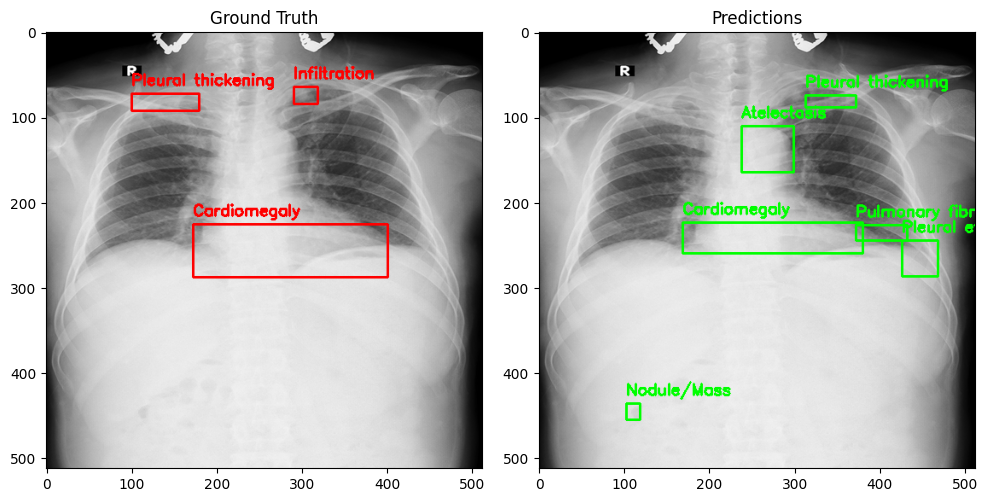

In [ ]:
import torch
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Class dictionary
classes = {
    'Cardiomegaly': 1,
    'Pleural thickening': 2,
    'Pulmonary fibrosis': 3,
    'Pleural effusion': 4,
    'Nodule/Mass': 5,
    'Infiltration': 6,
    'Consolidation': 7,
    'Atelectasis': 8,
    'Pneumothorax': 9
}

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

# Load the SSD model architecture
model = models.detection.ssd300_vgg16(weights=None)

model.load_state_dict(torch.load('/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/EXPORT/model_it1/model_epoch_150.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

def predict(image_tensor):
    with torch.no_grad():
        predictions = model(image_tensor)

    # Filter to keep only one prediction per class
    unique_predictions = []
    seen_classes = set()
    for i, label in enumerate(predictions[0]['labels']):
        if label.item() not in seen_classes:
            unique_predictions.append({
                'boxes': predictions[0]['boxes'][i],
                'labels': label,
                'scores': predictions[0]['scores'][i]
            })
            seen_classes.add(label.item())

    # Convert the list of unique predictions back to the original format
    filtered_predictions = {
        'boxes': torch.stack([pred['boxes'] for pred in unique_predictions]),
        'labels': torch.tensor([pred['labels'] for pred in unique_predictions]),
        'scores': torch.tensor([pred['scores'] for pred in unique_predictions])
    }

    return [filtered_predictions]

# Function to load ground truth bounding boxes from CSV
def load_ground_truth_bboxes(csv_file, image_id):
    df = pd.read_csv(csv_file)
    # Filter rows for the specific image_id
    gt_bboxes = df[df['image_id'] == image_id]
    return gt_bboxes

def plot_boxes(image_path, predictions, csv_file):
    # Read the original image for both GT and predictions
    image_gt = cv2.imread(image_path)  # For ground truth
    image_pred = cv2.imread(image_path)  # For predictions

    # Extract image_id from the image file name (remove the .png extension)
    image_id = image_path.split('/')[-1].replace('.png', '')

    # Load ground truth bounding boxes from the CSV
    gt_bboxes = load_ground_truth_bboxes(csv_file, image_id)

    # Plot ground truth boxes (Red)
    for _, row in gt_bboxes.iterrows():
        x1, y1, x2, y2 = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        class_name = row['class_name'] if 'class_name' in row else "Unknown"
        print(f"Ground Truth Class: {class_name}, Bounding Box: ({x1}, {y1}), ({x2}, {y2})")
        cv2.rectangle(image_gt, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)  # Red for GT
        cv2.putText(image_gt, f"{class_name}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # Plot predicted boxes (Green)
    for i, box in enumerate(predictions[0]['boxes']):
        x1, y1, x2, y2 = box.int().tolist()
        class_name = predictions[0]['labels'][i].item()
        class_name_str = [k for k, v in classes.items() if v == class_name][0]  # Get class name from dictionary
        print(f"Predicted Class: {class_name_str}, Bounding Box: ({x1}, {y1}), ({x2}, {y2})")
        cv2.rectangle(image_pred, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for predictions
        cv2.putText(image_pred, f"{class_name_str}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display the images separately
    plt.figure(figsize=(10, 5))

    # Ground Truth
    plt.subplot(1, 2, 1)
    plt.title("Ground Truth")
    plt.imshow(cv2.cvtColor(image_gt, cv2.COLOR_BGR2RGB))

    # Predictions
    plt.subplot(1, 2, 2)
    plt.title("Predictions")
    plt.imshow(cv2.cvtColor(image_pred, cv2.COLOR_BGR2RGB))

    plt.tight_layout()
    plt.show()

# Example of how to call the function with image and CSV
image_path = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/VALIDATION/00f2f97f74e086e1f82acc285ee4a5c5.png'
csv_file = '/content/drive/Shareddrives/cxraide/ssd300_vgg16/VERSION_2/val.csv'

# Load and preprocess the image
image_tensor = load_image(image_path)

# Make prediction
predictions = predict(image_tensor)

# Plot and compare the boxes
plot_boxes(image_path, predictions, csv_file)

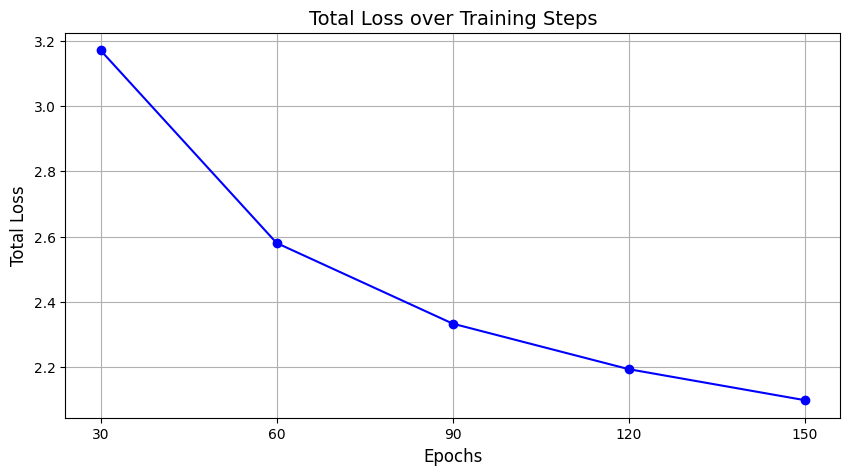

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Updated data for the new line graph
steps_new = [30, 60, 90, 120, 150]
total_loss_new = [
    3.17077390, 2.58012255, 2.33305539, 2.19353834, 2.09850803,
]

# Create the updated plot
plt.figure(figsize=(10, 5))
plt.plot(steps_new, total_loss_new, marker='o', linestyle='-', color='blue')

# Add titles and labels
plt.title('Total Loss over Training Steps', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Total Loss', fontsize=12)

# Set x-axis ticks to display every 500th step
plt.xticks(range(30, 180, 30), fontsize=10)

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()